In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
# Summary-like from Tensorflow
# from torchinfo import summary
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
from statistics import mean
# WFDB
import wfdb
# ==== LOCAL LIBS ====
import ecg_tools_lite as et
import evaluator as eva
import trainer as tr
import models as mod
# math
import math

In [2]:
# What are you trying to do?
create_new_model = True
create_new_res = True
# If create_new_model is True, epochs must have a value
epochs = 5
# If create_new_model is False, load_model_name must have a value
load_model_name = 'saved_model_dict.pt'
ecg_saved_res = 'res_pt_full.npy'
# Normalization option (either option 0 or 1)
norm_option = 2

In [3]:
ecg_noisy = torch.from_numpy(np.load('all_none_fs1024_e06.npy')).cuda().double()
ecg_clean = torch.from_numpy(np.load('all_none_fs1024_e24.npy')).cuda().double()

# Acquire original shape
x = ecg_noisy.shape[0]
y = ecg_noisy.shape[2]
z = ecg_noisy.shape[1]

# Reshape
ecg_noisy = torch.reshape( ecg_noisy, (x, y, z))
ecg_clean = torch.reshape( ecg_clean, (x, y, z))

print(f'New shape: {ecg_noisy.shape}')

# == Basic Normalization technique (norm from 0 to 1)
# ecg_noisy = et.norm_basic( ecg_noisy )
# ecg_clean = et.norm_basic( ecg_clean )

# == Normalization technique (Norm from -1 to 1)
ecg_noisy = et.norm_sig( ecg_noisy )
ecg_clean = et.norm_sig( ecg_clean )

# ecg_noisy = ecg_noisy.cpu().numpy().flatten()
# ecg_clean = ecg_clean.cpu().numpy().flatten()

# ecg_noisy = et.realign_all_chunks(ecg_noisy, ecg_clean)

New shape: torch.Size([5544, 1, 1024])


<Figure size 1440x576 with 0 Axes>

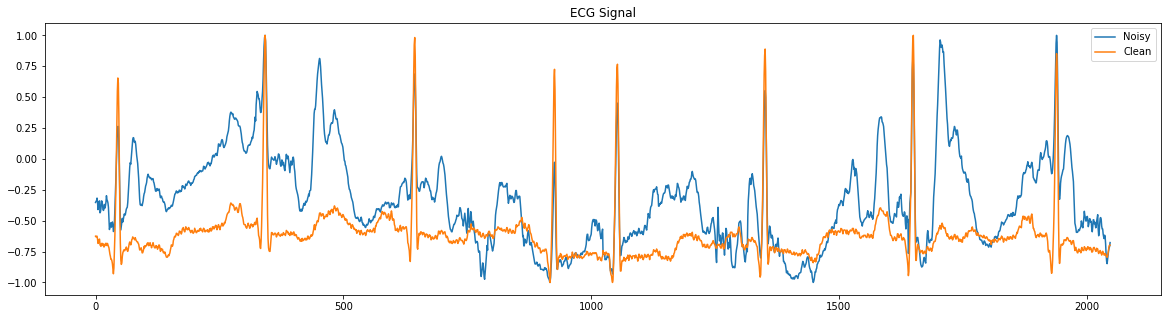

In [4]:
et.ecg_plot( [ecg_noisy.cpu().numpy().flatten(), ecg_clean.cpu().numpy().flatten()], ['Noisy', 'Clean'], length=2048, index=0)

In [5]:
# Train a new model
if create_new_model:
    # move model to be run by gpu
    model = mod.ae_sampler().cuda()
    model.double()
    # start training the model
    losses = tr.train_model( model=model,
                    epochs=epochs, 
                    ecg_noisy=ecg_noisy, 
                    ecg_clean=ecg_clean,
                    train_pct=0.8)
    save_file_name = 'model_' + str(et.get_local_time()) + '.pt';
    # saved model will have model_YYYY-MM-DD_hhmm.pt format
    torch.save(model.state_dict(), save_file_name)
    print(f'Saved {et.get_local_time()}')
# load model instead if existing
else:
    model = mod.ae_sampler().cuda()
    model.double()
    model.load_state_dict(torch.load(load_model_name))
    model.to('cuda')
    model.eval()
    print( f'Model {load_model_name} has been loaded')

Model saved_model_dict.pt has been loaded


In [6]:
if create_new_model == True or create_new_res == True:
    ecg_res = et.concat_pt_full(model, ecg_noisy)
    et.get_local_time()
else:
    ecg_res = np.load( ecg_saved_res )

ecg_res = ecg_res.flatten()

<Figure size 1440x576 with 0 Axes>

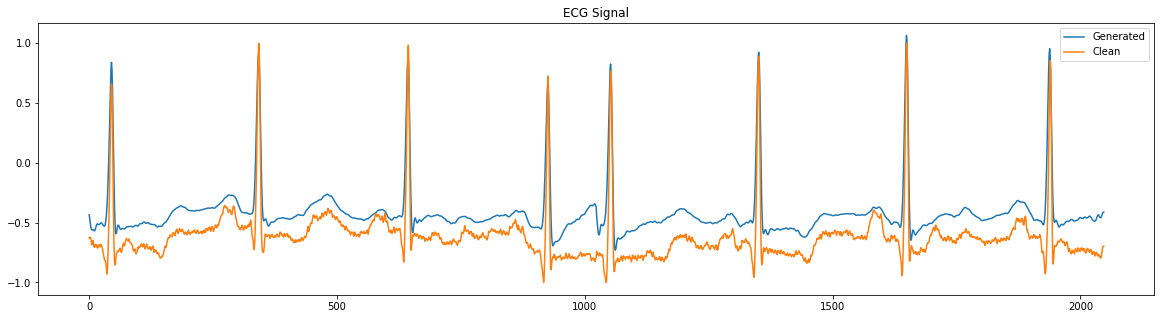

In [7]:
et.ecg_plot( [ecg_res, ecg_clean.cpu().numpy().flatten()], ['Generated', 'Clean'], length=2048, index=0)

<Figure size 1440x576 with 0 Axes>

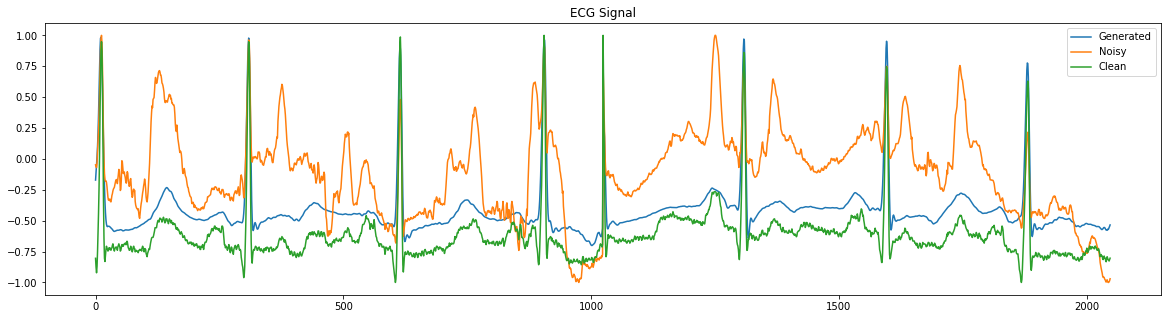

In [24]:
et.ecg_plot( [ecg_res, ecg_noisy.cpu().numpy().flatten(), ecg_clean.cpu().numpy().flatten()], ['Generated', 'Noisy','Clean'], length=2048, index=1)

<Figure size 1440x576 with 0 Axes>

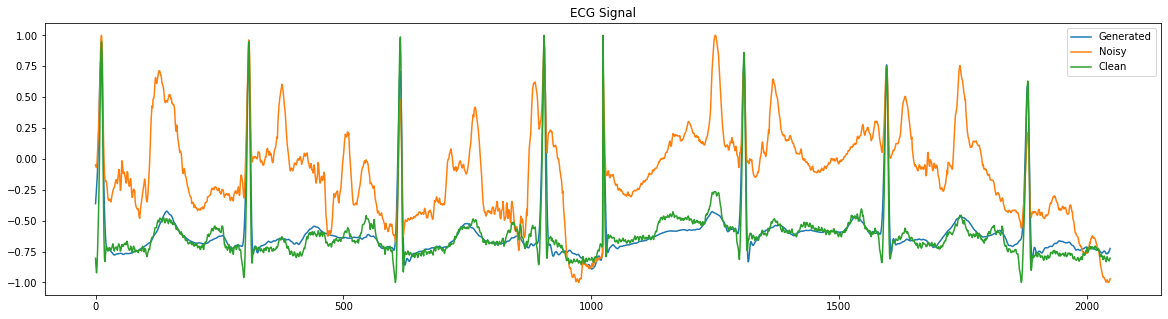

In [26]:
# ecg_res_aligned = et.realign_starting(ecg_res.flatten(), ecg_clean.cpu().numpy().flatten())
et.ecg_plot( [ecg_res_aligned, ecg_noisy.cpu().numpy().flatten(), ecg_clean.cpu().numpy().flatten()], ['Generated', 'Noisy','Clean'], length=2048, index=1)